In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#L'importation de l'algorithme regression linear
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
HOURS = {7:00, 7:30, 8:00, 8:30, 9:00, 9:30, 10:00, 10:30, 11:00, 11:30, 12:00, 12:30, 13:00, 13:30, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30, 17:00, 17:30, 18:00, 18:30, 19:00, 19:30, 20:00} # reference from dataset folder
DATA_PATH = "./Behavior_of_the_urban_traffic_of_the_city_of_Sao_Paulo_in_Brazil.csv"
TARGET_VAR = "Accident victim"
MONDAY  = 26
TUESDAY = 53
WEDNESDAY = 80
THURSDAY = 107
FRIDAY = 134
DAYS_TO_CODE = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5}

In [3]:
#data loading from csv file 
def load_data(path:str=DATA_PATH, sep:str=";"):
    try:
        df = pd.read_csv(path, sep=sep)
        df = df.drop(columns=["Fire", "Immobilized bus", "Broken Truck", "Defect in the network of trolleybuses", "Vehicle excess", "Fire vehicles", "Manifestations", "Tree on the road", "Point of flooding", "Intermittent Semaphore",'Occurrence involving freight']) 
        df = pd.DataFrame.reindex(df,columns = ['Hour (Coded)','Running over', 'Lack of electricity', 'Incident involving dangerous freight','Slowness in traffic (%)','Semaphore off','Accident victim'])
        print("Data loaded with success")
        return df
    except FileNotFoundError:
        print("Check your data directory! Nothing there yet...")
        return False

In [4]:
#preview data
df = load_data()
df.head(16)

Data loaded with success


,Hour (Coded),Running over,Lack of electricity,Incident involving dangerous freight,Slowness in traffic (%),Semaphore off,Accident victim
0,1,0,0,0,"4,1",0,0
1,2,0,0,0,"6,6",0,0
2,3,0,0,0,"8,7",0,0
3,4,0,0,0,"9,2",0,0
4,5,0,0,0,"11,1",0,0
5,6,0,0,0,"10,9",0,0
6,7,0,0,0,"8,3",0,0
7,8,0,0,0,"8,2",0,0
8,9,0,0,0,"7,6",0,0
9,10,0,0,0,"6,4",0,0


In [5]:
#check for null values
df.isnull().sum()

Hour (Coded)                            0
Running over                            0
Lack of electricity                     0
Incident involving dangerous freight    0
Slowness in traffic (%)                 0
Semaphore off                           0
Accident victim                         0
dtype: int64

In [6]:
print(f"Dataframe shape: {df.shape}\n")
df.info()

Dataframe shape: (135, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Hour (Coded)                          135 non-null    int64 
 1   Running over                          135 non-null    int64 
 2   Lack of electricity                   135 non-null    int64 
 3   Incident involving dangerous freight  135 non-null    int64 
 4   Slowness in traffic (%)               135 non-null    object
 5   Semaphore off                         135 non-null    int64 
 6   Accident victim                       135 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.5+ KB


In [7]:
df.describe()

,Hour (Coded),Running over,Lack of electricity,Incident involving dangerous freight,Semaphore off,Accident victim
count,135.00000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,14.00000,0.118519,0.118519,0.007407,0.125926,0.422222
std,7.81789,0.346665,0.504485,0.086066,0.464077,0.696116
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,27.00000,2.000000,4.000000,1.000000,4.000000,3.000000


In [8]:
def transform_target(df, target_var='Slowness in traffic (%)', to=float):
    df[target_var] = df[target_var].str.replace(',', '.').astype(to)
transform_target(df)

In [9]:
# New attribute
def transform_days(df, create_column=False, to_numerical=False):
    #check is day column exists if not create
    #if numerical transformation, go from day to number
    #else go from number to day names
    if create_column:
        df['Day'] = '0'

    position=-1
    if to_numerical is False:
        for idx in df.index:
            if idx <= MONDAY:
                df.iloc[idx, position] = 'Monday'
            elif idx <= TUESDAY:
                df.iloc[idx, position] = 'Tuesday'
            elif idx <= WEDNESDAY:
                df.iloc[idx, position] = 'Wednesday'
            elif idx <= THURSDAY:
                df.iloc[idx, position] = 'Thursday'
            elif idx <= FRIDAY:
                df.iloc[idx, position] = 'Friday'
    else:
        df_values = df["Day"].unique()
        for key, value in DAYS_TO_CODE.items():
            assert key in df_values, "First transform your data into weekday by setting to_numerical=False, then apply the numerical transformation"
            df.loc[(df.Day == key), 'Day'] = value
        df['Day'] = df['Day'].astype(int)
        
transform_days(df, create_column=True)

In [10]:
# Create code to hour dict
def set_hours_dict(df, hours:dict =HOURS)-> dict:
    hours_arr = []

    for hour, minute in hours.items():
      s1 = str(hour) + ':' + '00'
      s2 = str(hour) + ':' + str(minute)
      if hour != 20:
        hours_arr.append(s1)
        hours_arr.append(s2)
      else:
        hours_arr.append(s1)

    code_to_hour = {}
    for code, hour in zip(df['Hour (Coded)'], hours_arr):
      code_to_hour[code] = hour

    return code_to_hour

code_to_hour = set_hours_dict(df)

def code_hour(code):
  return code_to_hour[code]

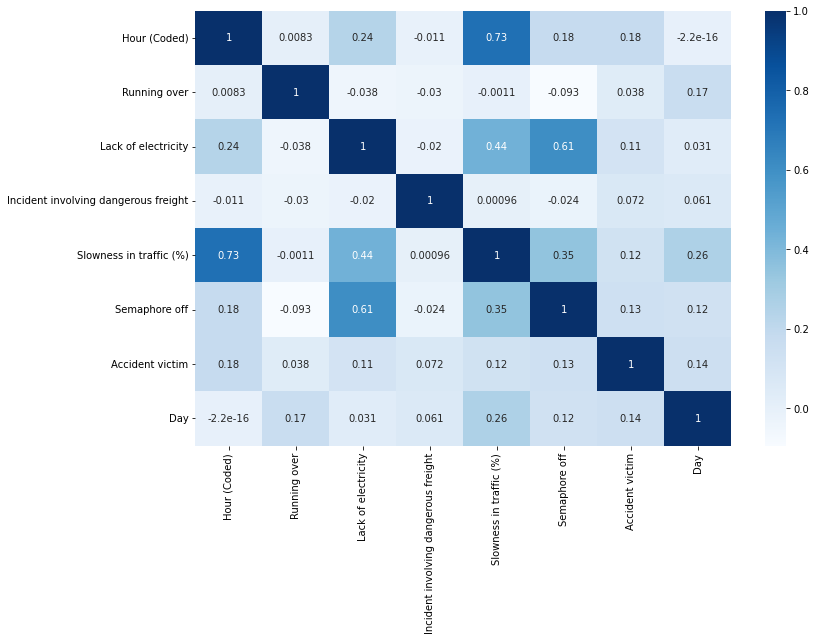

In [11]:
transform_days(df, to_numerical=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.show()

In [12]:
corr_matrix = df.corr()
corr_matrix['Accident victim'].sort_values(ascending=False)

Accident victim                         1.000000
Hour (Coded)                            0.181008
Day                                     0.143495
Semaphore off                           0.134497
Slowness in traffic (%)                 0.121730
Lack of electricity                     0.111446
Incident involving dangerous freight    0.071968
Running over                            0.038484
Name: Accident victim, dtype: float64

array([[<AxesSubplot:xlabel='Accident victim', ylabel='Accident victim'>,
        <AxesSubplot:xlabel='Hour (Coded)', ylabel='Accident victim'>],
       [<AxesSubplot:xlabel='Accident victim', ylabel='Hour (Coded)'>,
        <AxesSubplot:xlabel='Hour (Coded)', ylabel='Hour (Coded)'>]],
      dtype=object)

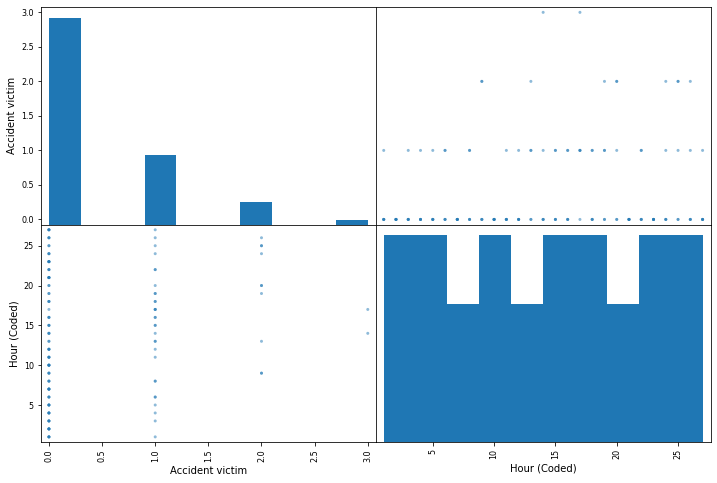

In [13]:
attributes = ["Accident victim", "Hour (Coded)"]
scatter_matrix(df[attributes], figsize=(12, 8))

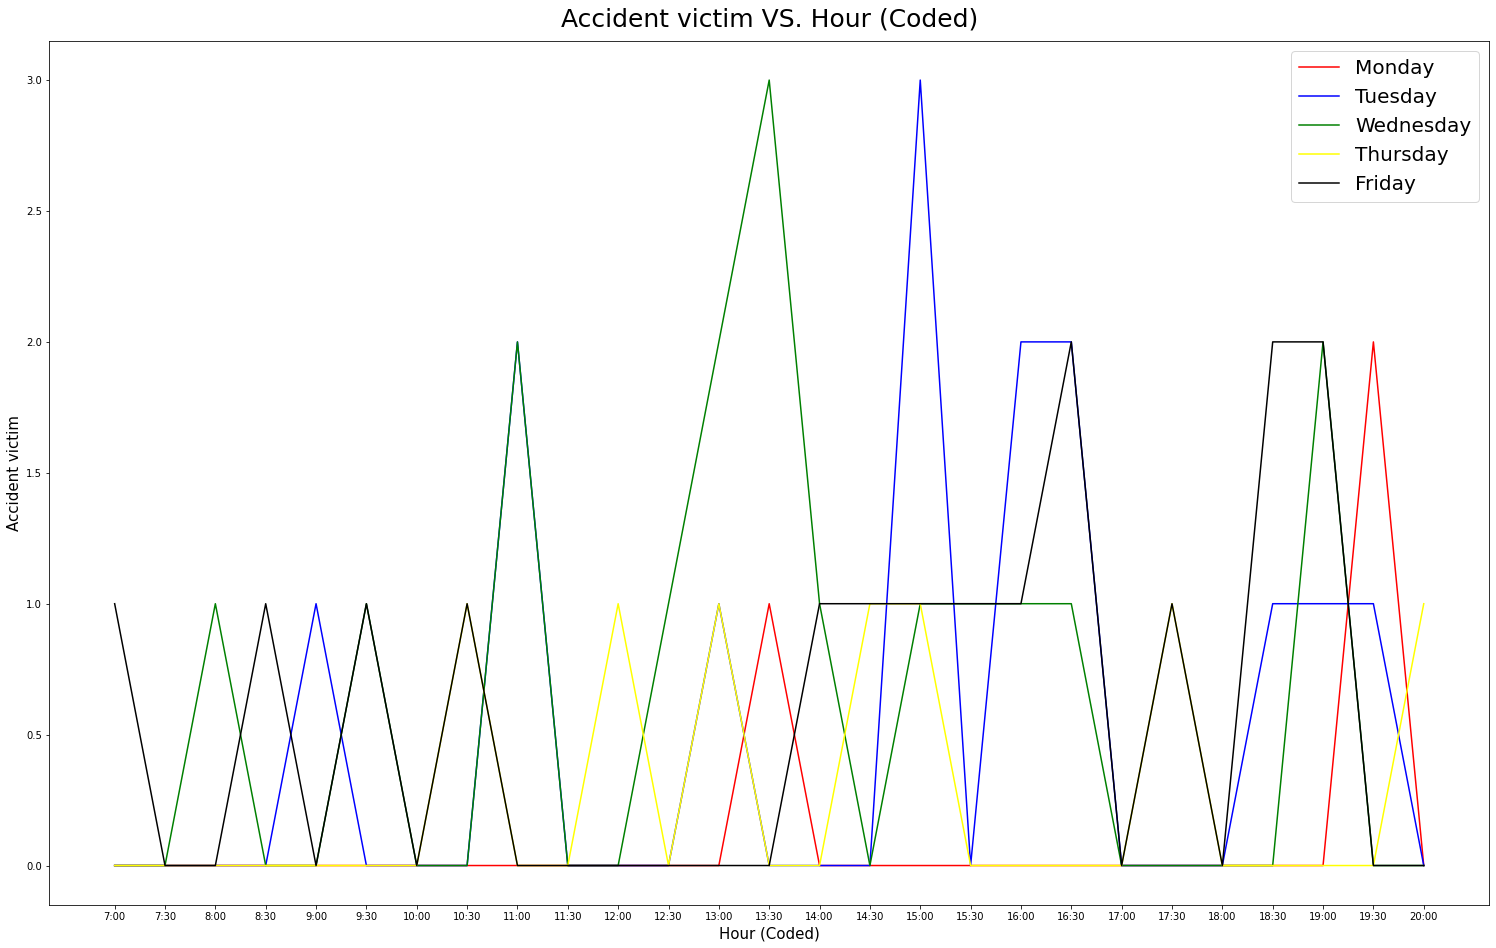

In [14]:
def slowness_over_time(df, coded_hours=False):
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_axes([0, 0, 1, 1])

    colors = {'Monday': 'r', 'Tuesday': 'b', 'Wednesday': 'g', 'Thursday': 'yellow', 'Friday':'black'}
    transform_days(df)
    for e in df['Day'].unique():
        subset = df[df['Day'] == e]
        ax.plot(subset['Hour (Coded)'], subset['Accident victim'],color=colors[e])

    ax.set_title('Accident victim VS. Hour (Coded)', fontsize=25, pad=15)
    ax.set_xlabel('Hour (Coded)', fontsize=15)
    ax.set_ylabel('Accident victim', fontsize=15)
    
    if coded_hours is False:
        ax.set_xticks(range(1, 28))
        ax.set_xticklabels(map(code_hour, subset['Hour (Coded)'].unique()))

    ax.legend(colors, fontsize=20)

    plt.show()
slowness_over_time(df)
transform_days(df, to_numerical=True)

In [15]:
df.groupby('Day')['Accident victim'].mean()

Day
1    0.111111
2    0.518519
3    0.629630
4    0.259259
5    0.592593
Name: Accident victim, dtype: float64

In [16]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Hour (Coded)"])

# Verifying stratified distribution
print("Train set class proportions:\n")
print(train_set["Hour (Coded)"].value_counts() / len(train_set))
print("\nFull set:")
print(df["Hour (Coded)"].value_counts() / len(df))

Train set class proportions:

20    0.037037
16    0.037037
9     0.037037
1     0.037037
18    0.037037
2     0.037037
12    0.037037
23    0.037037
25    0.037037
27    0.037037
3     0.037037
26    0.037037
21    0.037037
13    0.037037
10    0.037037
8     0.037037
19    0.037037
22    0.037037
24    0.037037
5     0.037037
15    0.037037
7     0.037037
6     0.037037
4     0.037037
14    0.037037
17    0.037037
11    0.037037
Name: Hour (Coded), dtype: float64

Full set:
1     0.037037
15    0.037037
26    0.037037
25    0.037037
24    0.037037
23    0.037037
22    0.037037
21    0.037037
20    0.037037
19    0.037037
18    0.037037
17    0.037037
16    0.037037
14    0.037037
2     0.037037
13    0.037037
12    0.037037
11    0.037037
10    0.037037
9     0.037037
8     0.037037
7     0.037037
6     0.037037
5     0.037037
4     0.037037
3     0.037037
27    0.037037
Name: Hour (Coded), dtype: float64


In [17]:
X_train = train_set.drop("Accident victim", axis=1)
y_train = train_set["Accident victim"].copy()

In [18]:
x_num_cols = X_train.nunique()[X_train.nunique() > 2].keys()
x_num_cols = x_num_cols.drop('Day')
numerical_data = list(x_num_cols)

In [19]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
full_pipeline = ColumnTransformer([("num", num_pipeline, numerical_data)], remainder='passthrough')

In [20]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [21]:
#Model Buildibg
# tree_reg = DecisionTreeRegressor(random_state=42)
# scores = cross_val_score(tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
# tree_rmse_scores = np.sqrt(-scores)

In [22]:
#Building model linear regression
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [23]:
data = {
    "Model":["Linear Reg"],
    "Mean Score": [lin_rmse_scores.mean()],
    "Standard Deviation": [lin_rmse_scores.std()]
}
scores_df = pd.DataFrame(data)
scores_df

,Model,Mean Score,Standard Deviation
0,Linear Reg,0.68066,0.193808


In [24]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [10, 12, 14, 16, 18]},
# ]

# forest_reg = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train_prepared, y_train)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 185.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False],
                          'max_features': [10, 12, 14, 16, 18],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
# best_grid_model = grid_search.best_estimator_
# print("Best model paramateres:", grid_search.best_params_)

Best model paramateres: {'max_features': 2, 'n_estimators': 3}


In [26]:
# feature_importances = grid_search.best_estimator_.feature_importances_
# sorted(zip(feature_importances, list(X_train)), reverse=True)

[(0.4184765321610275, 'Lack of electricity'),
 (0.33420066537398113, 'Hour (Coded)'),
 (0.1589924628493896, 'Day'),
 (0.034166528327850686, 'Slowness in traffic (%)'),
 (0.028240548760631933, 'Running over'),
 (0.02183258411793304, 'Incident involving dangerous freight'),
 (0.004090678409186309, 'Semaphore off')]

In [27]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Accident victim", axis=1)
y_test = test_set["Accident victim"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [28]:
final_rmse

0.8725347399547961

In [29]:
# Here are a few examples...
predictions = final_predictions[:10]
actual_results = y_test[:10]

for p, a in zip(predictions, actual_results):
    print("Predicted: {:.2f} - Expected: {}".format(p, a))

Predicted: 0.33 - Expected: 0
Predicted: 0.00 - Expected: 0
Predicted: 0.33 - Expected: 0
Predicted: 0.33 - Expected: 1
Predicted: 0.33 - Expected: 2
Predicted: 0.00 - Expected: 2
Predicted: 0.33 - Expected: 0
Predicted: 0.00 - Expected: 1
Predicted: 0.33 - Expected: 0
Predicted: 1.33 - Expected: 0
